# Methods and models for multivariate data analysis. Lab 2

## <font color='darkblue'> **Aleksandr Shirokov, J4133c** </font>

In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import statsmodels

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats.distributions import norm

from definitions import ROOT_DIR

%matplotlib inline

In [2]:
for library in [np, pd, sns, scipy, sklearn, statsmodels]:
    print(f'{library.__name__}=={library.__version__}')

numpy==1.20.1
pandas==1.2.3
seaborn==0.11.2
scipy==1.6.1
sklearn==1.0.1
statsmodels==0.13.1


## Dataset

To use dataset you need:

- Download dataset from this [link](https://www.kaggle.com/devbcdestiller/bitcoin-usdt-price-trend-indicators) and save it in `data` folder with filename `data.csv`

- Apply several feature engineering using code below:

In [3]:
DATA_PATH = ROOT_DIR / 'data'

data = pd.read_csv(DATA_PATH / 'data.csv')

**Feature engineering for dataset**

In [4]:
data['quantile_Volume'] = pd.qcut(data['Volume'], q=4)
data['quantile_RSI'] = pd.qcut(data['RSI'], q=4)
data['quantile_STOCHRSI-K'] = pd.qcut(data['STOCHRSI-K'], q=4)
data['quantile_STOCHRSI-D'] = pd.qcut(data['STOCHRSI-D'], q=4)
data['month'] = data.dt.apply(lambda x: pd.to_datetime(x).month)
data = data.drop('dt', axis=1)

## Additional Data Preprocessing

In [5]:
quantile_map = dict(
    zip(
        map(
            lambda x: str(x), 
            np.sort(data['quantile_Volume'].unique())
        ), 
        range(1, 5)
    )
)
quantile_map

{'(5.885999999999999, 1560.863]': 1,
 '(1560.863, 2298.493]': 2,
 '(2298.493, 3550.281]': 3,
 '(3550.281, 44239.812]': 4}

In [6]:
columns = data.columns

target = ['Close']
features = ['Open', 'Volume', 'RSI', 'MACD Signal', 'month', 'STOCHRSI-D']
categories = ['quantile_Volume']

In [7]:
data['quantile_Volume']= data['quantile_Volume'].astype(str).map(quantile_map)

In [8]:
for col in features + categories:
    data[col] = data[col].fillna(data[col].median())

In [9]:
data = data[features + categories + target]
columns = features + categories + target

## Subtask 1.


*Non-parametric estimation of PDF in:*

- form of histogram

- using kernel density function for MRV (or probability law in case of discrete MRV)


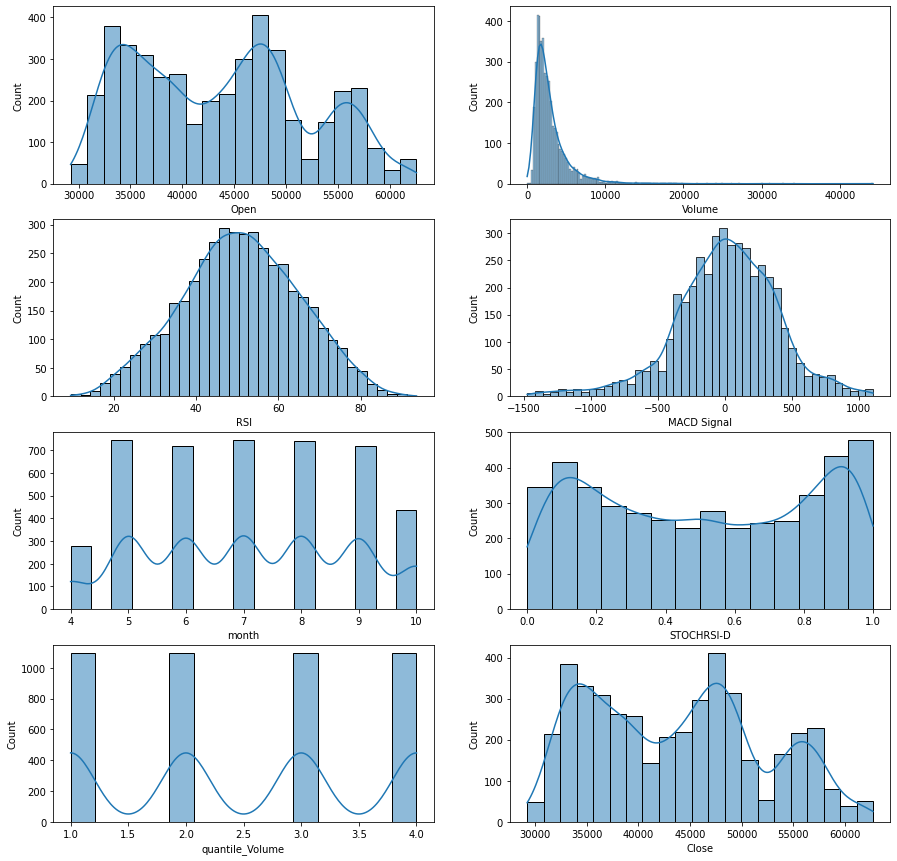

In [10]:
fig, ax = plt.subplots(4, 2, figsize=(15,15))

for ax, cols in zip(ax.flat, columns):
    sns.histplot(
        data[cols], 
        ax=ax, 
        kde=True
    )

## Subtask 2.

*An estimation of multivariate mathematical expectation and variance*.


In [11]:
data[columns].mean()

Open               43744.748055
Volume              3018.940768
RSI                   50.929004
MACD Signal            9.319127
month                  7.101575
STOCHRSI-D             0.510336
quantile_Volume        2.499658
Close              43746.064022
dtype: float64

In [12]:
data[columns].var()

Open               6.876476e+07
Volume             6.748538e+06
RSI                2.007612e+02
MACD Signal        1.496410e+05
month              3.127351e+00
STOCHRSI-D         9.952140e-02
quantile_Volume    1.250514e+00
Close              6.880793e+07
dtype: float64

## Subtask 3.

*Non-parametric estimation of conditional distributions, mathematical expectations and variances.*

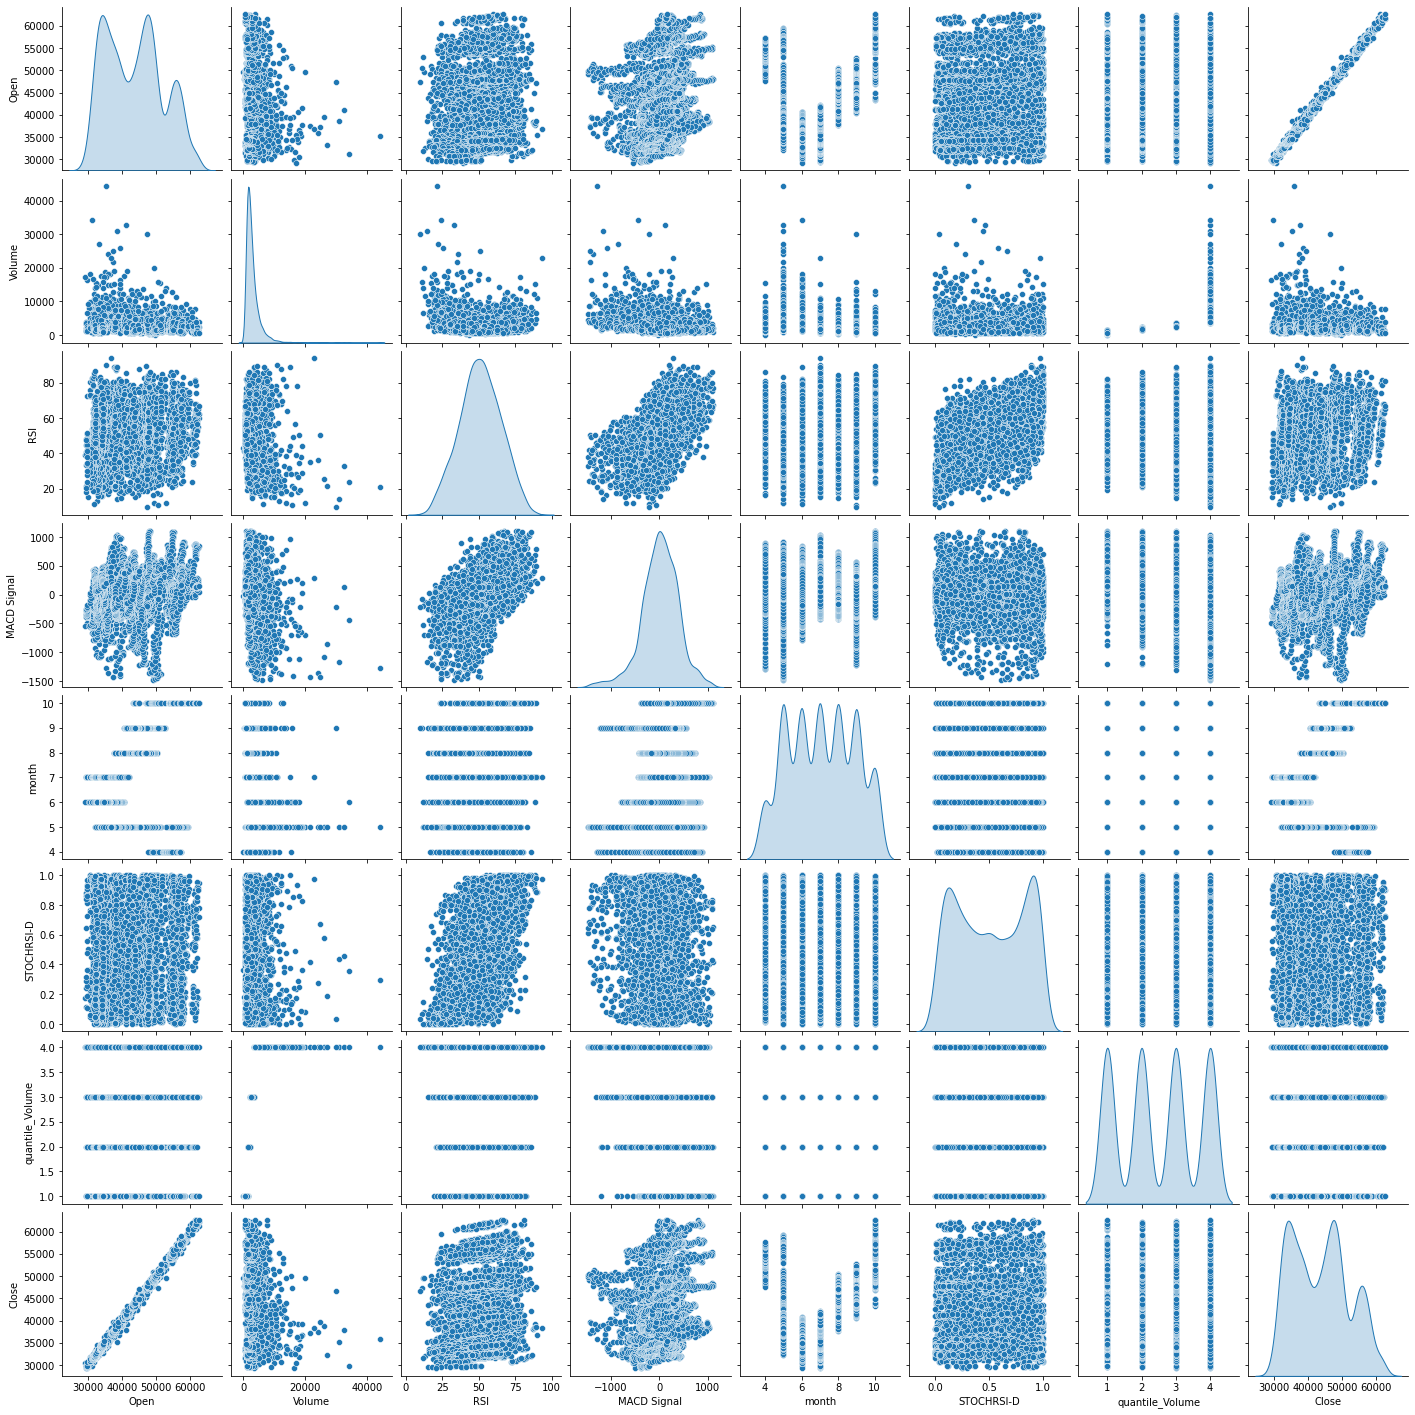

In [13]:
sns.pairplot(data[columns], diag_kind='kde')
plt.show()

**Conditional distributions**

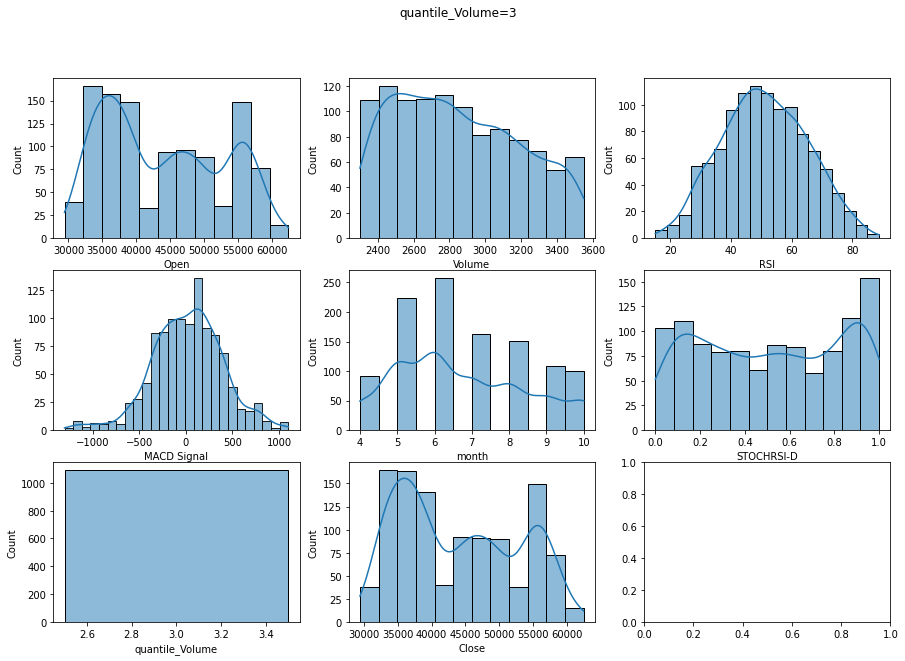

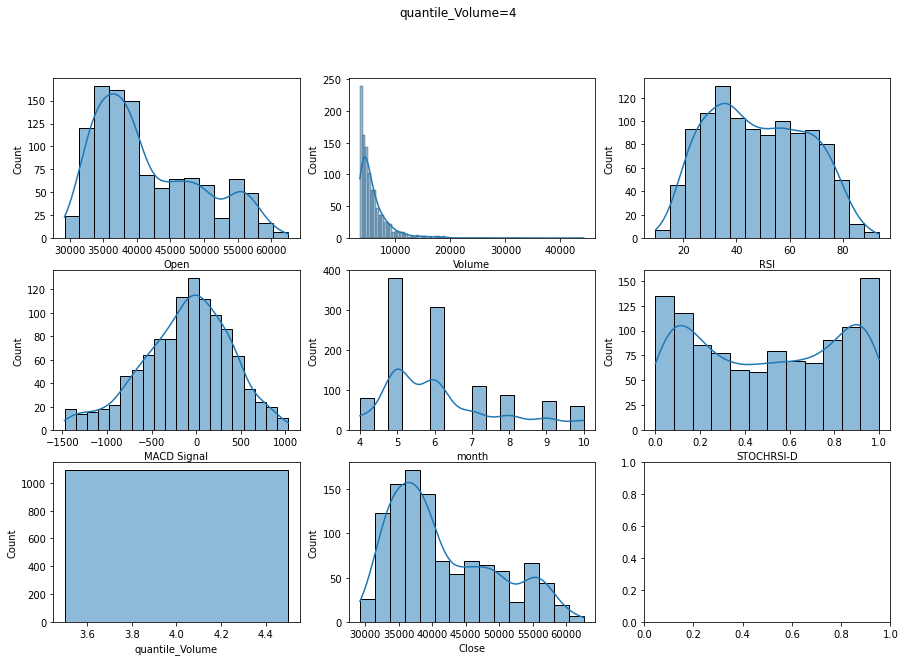

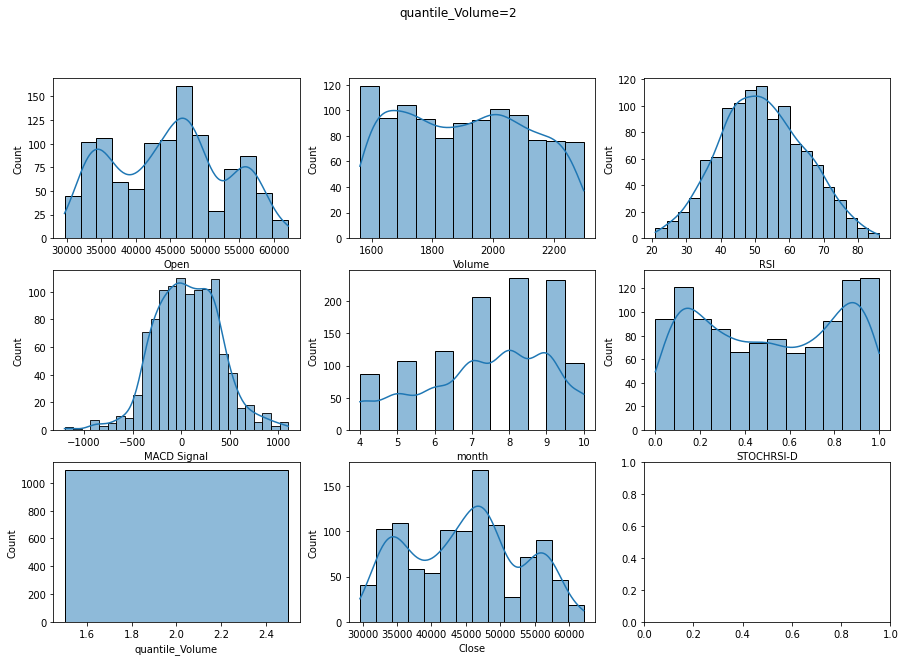

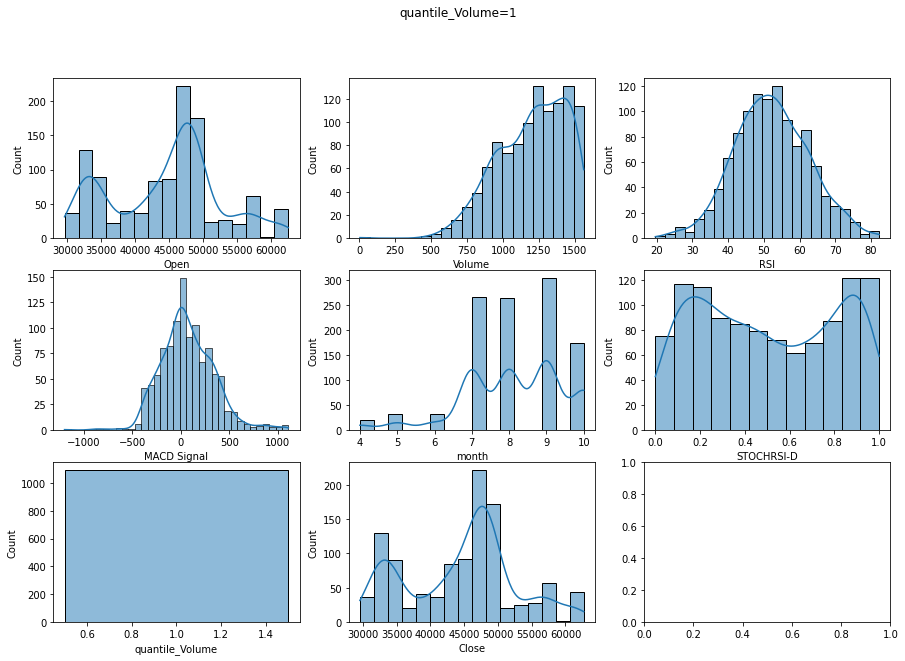

In [14]:
conditions = data['quantile_Volume'].unique()

for condition in conditions:
    condition_df = data[data['quantile_Volume'] == condition]
   
    fig, ax = plt.subplots(3, 3, figsize=(15,10))

    for ax, cols in zip(ax.flat, columns):
        sns.histplot(
            condition_df[cols],
            ax=ax,
            kde=True
        )
    
    fig.suptitle(f'quantile_Volume={condition}')
    plt.show()


In [15]:
for condition in conditions:
    print('_________________________')
    print(f'VAR quantile_Volume={condition}')
    print('_________________________')
    condition_df = data[data['quantile_Volume'] == condition]
    display(condition_df[columns].drop(
        ['quantile_Volume'],
        axis=1
    ).var())
    print('_________________________')
    print(f'MEAN quantile_Volume={condition}')
    print('_________________________')
    display(condition_df[columns].drop(
        ['quantile_Volume'],
        axis=1
    ).mean())

_________________________
VAR quantile_Volume=3
_________________________


Open           7.559168e+07
Volume         1.198644e+05
RSI            1.963207e+02
MACD Signal    1.432975e+05
month          3.077789e+00
STOCHRSI-D     9.968853e-02
Close          7.560658e+07
dtype: float64

_________________________
MEAN quantile_Volume=3
_________________________


Open           43955.143799
Volume          2847.455732
RSI               51.065099
MACD Signal       17.243959
month              6.715068
STOCHRSI-D         0.517946
Close          43960.847087
dtype: float64

_________________________
VAR quantile_Volume=4
_________________________


Open           6.151362e+07
Volume         1.261243e+07
RSI            3.359093e+02
MACD Signal    2.466097e+05
month          2.480985e+00
STOCHRSI-D     1.077437e-01
Close          6.151082e+07
dtype: float64

_________________________
MEAN quantile_Volume=4
_________________________


Open           41599.232237
Volume          6118.444216
RSI               48.224974
MACD Signal     -113.542551
month              6.180822
STOCHRSI-D         0.503308
Close          41587.903516
dtype: float64

_________________________
VAR quantile_Volume=2
_________________________


Open           6.686893e+07
Volume         4.520472e+04
RSI            1.530043e+02
MACD Signal    1.122182e+05
month          2.996524e+00
STOCHRSI-D     9.792741e-02
Close          6.693694e+07
dtype: float64

_________________________
MEAN quantile_Volume=2
_________________________


Open           44868.400411
Volume          1909.361322
RSI               52.222315
MACD Signal       64.243045
month              7.380822
STOCHRSI-D         0.513545
Close          44867.676795
dtype: float64

_________________________
VAR quantile_Volume=1
_________________________


Open           6.470311e+07
Volume         5.712776e+04
RSI            1.078101e+02
MACD Signal    7.512455e+04
month          1.830923e+00
STOCHRSI-D     9.287287e-02
Close          6.472727e+07
dtype: float64

_________________________
MEAN quantile_Volume=1
_________________________


Open           44555.475383
Volume          1202.160961
RSI               52.202464
MACD Signal       69.277297
month              8.128650
STOCHRSI-D         0.506549
Close          44567.078905
dtype: float64

## Subtask 4.

*An estimation of pair correlation coefficients, confidence intervals for them and significance levels.*

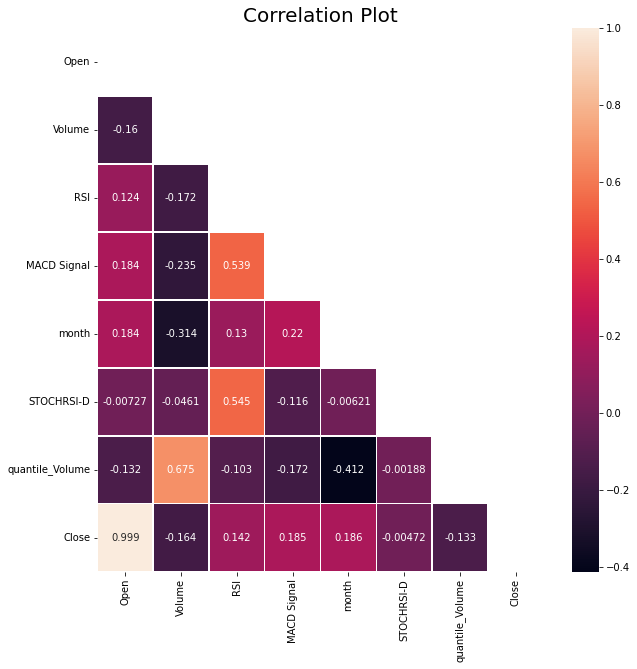

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

corr = data[columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            ax=ax, 
            vmax=1, 
            fmt='.3g', 
            linewidths=.5)

ax.set_title('Correlation Plot', fontsize=20)
plt.show()

In [17]:
from scipy import stats

alpha = 0.05

for index, col in enumerate(columns):
    for k in range(index + 1, len(columns)):
        col2 = columns[k]
        x1, x2 = data[col], data[col2]
        coeff, p = stats.pearsonr(x1, x2)
        coeff_z = np.arctanh(coeff)
        std = 1 / np.sqrt(x1.size-3)
        z = stats.norm.ppf(1 - alpha / 2)
        low_z, high_z = coeff_z - z * std, coeff_z + z * std

        print('%s - %s' % (col, col2))
        print('Correlation coeff = ', coeff)
        print('Confidence interval = ', low_z, high_z)
        print('-----')

Open - Volume
Correlation coeff =  -0.1602037807865391
Confidence interval =  -0.19121755367082682 -0.13197412186102087
-----
Open - RSI
Correlation coeff =  0.12373459355817426
Confidence interval =  0.09475021179754708 0.15399364360735304
-----
Open - MACD Signal
Correlation coeff =  0.18440336431545906
Confidence interval =  0.1569155456012341 0.21615897741104007
-----
Open - month
Correlation coeff =  0.18421833948538774
Confidence interval =  0.156724014360414 0.21596744617021996
-----
Open - STOCHRSI-D
Correlation coeff =  -0.0072734306024885755
Confidence interval =  -0.03689527477306015 0.02234815703674582
-----
Open - quantile_Volume
Correlation coeff =  -0.1318889709178212
Confidence interval =  -0.16228349168262343 -0.10304005987281747
-----
Open - Close
Correlation coeff =  0.9989101047057035
Confidence interval =  3.72751615009934 3.786759581909146
-----
Volume - RSI
Correlation coeff =  -0.17176973812469393
Confidence interval =  -0.20311135184535317 -0.14386792003554721


## Subtask 5 + 6.

**Task formulation**:

Predict target column `target = 'Close'` by columns:

```python
columns = [
    'Open', 
    'High', 
    'Low', 
    'Volume', 
    'RSI', 
    'MACD Signal', 
    'month', 
    'quantile_Volume'
]
```


In [18]:
X = data.drop(['Close'],axis=1) # predictors
y = data['Close'] # target

In [19]:
mae = []
rmse = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=i, 
        shuffle=True
    )
    lr = make_pipeline(
        StandardScaler(with_mean=False), 
        LinearRegression()
    )
    lr.fit(X_train, y_train)

    prediction = lr.predict(X_test)
    mae.append(
        mean_absolute_error(y_test, prediction)
    )
    rmse.append(
        mean_squared_error(y_test, prediction, squared=False)
    )

print(f'mean MAE = {np.mean(mae)}')
print(f'RMSE = {np.mean(rmse)}')

mean MAE = 217.542443091694
RMSE = 303.420152442206


In [20]:
mae, rmse

([209.6323171037079,
  224.64269870385027,
  222.1692031067128,
  212.69111608453403,
  218.9215693475555,
  231.17456620603232,
  209.69753042002748,
  214.3369350844295,
  220.07655884494957,
  212.08193601514054],
 [276.50072982512995,
  318.53618139153735,
  299.66881438844786,
  296.7443475225312,
  313.7422568923927,
  336.91524030282056,
  288.2668501898698,
  289.8202070487622,
  308.06617206986436,
  305.94072479070405])

In [21]:
alphas = np.linspace(0.001, 1, 100)

best_rmse = 100000
best_alpha = 100000
best_mae = 100000
for alpha in alphas: 
    mae = []
    rmse = []
    model = Lasso(alpha=alpha, max_iter=1000000)
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=0.2, 
            random_state=i, 
            shuffle=True
        )
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        mae.append(
            mean_absolute_error(y_test, prediction)
        )
        rmse.append(
            mean_squared_error(y_test, prediction, squared=False)
        )
    if np.mean(rmse) <= best_rmse:
        best_rmse = np.mean(rmse)
        best_alpha = alpha
        best_mae = np.mean(mae)


In [22]:
best_alpha, best_rmse

(0.767909090909091, 303.39560693988864)

In [23]:
alphas = np.linspace(0.001, 1, 100)

best_rmse = 100000
best_alpha = 100000
best_mae = 100000
for alpha in alphas: 
    mae = []
    rmse = []
    model = Ridge(alpha=alpha, max_iter=1000000)
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=0.2, 
            random_state=i, 
            shuffle=True
        )

        model.fit(X_train, y_train)

        prediction = model.predict(X_test)
        mae.append(
            mean_absolute_error(y_test, prediction)
        )
        rmse.append(
            mean_squared_error(y_test, prediction, squared=False)
        )
    if np.mean(rmse) <= best_rmse:
        best_rmse = np.mean(rmse)
        best_alpha = alpha
        best_mae = np.mean(mae)


In [24]:
best_alpha,best_rmse

(1.0, 303.4169257101388)

In [25]:
model = Lasso(alpha=0.767909090909091, max_iter=1000000)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True
)

predictions = np.array(lr.predict(X_train))
true_values = np.array(y_train)

residuals = true_values - predictions

## Subtask 7.

*Analyze the quality of regression model*


In [26]:
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor
)

In [27]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) 
    for i in range(len(X.columns))
]

In [28]:
vif_data

,feature,VIF
0,Open,21.822346
1,Volume,4.490120
2,RSI,32.136749
3,MACD Signal,1.852232
4,month,15.508952
5,STOCHRSI-D,7.393802
6,quantile_Volume,10.405280


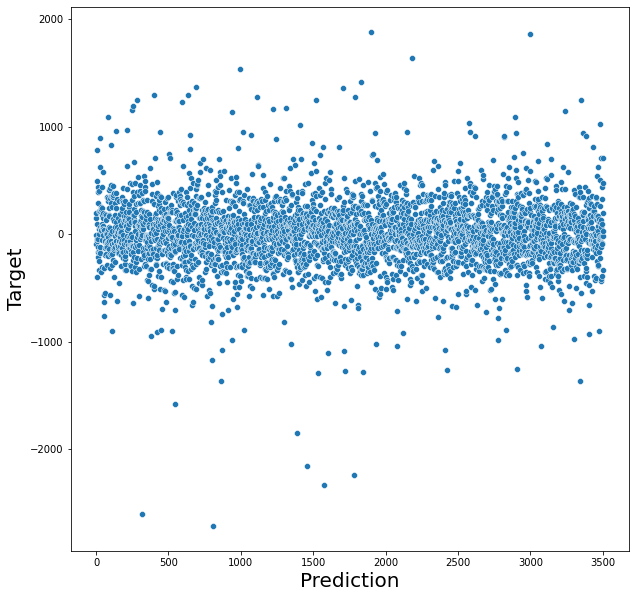

In [29]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x=[i for i in range(predictions.shape[0])], 
    y=residuals, 
    ax=ax
)

ax.set_xlabel('Prediction', fontsize=20)
ax.set_ylabel('Target', fontsize=20)
plt.show()

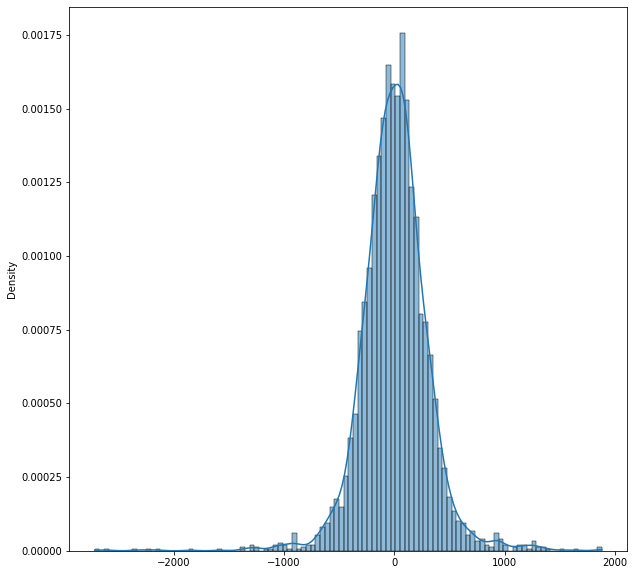

In [30]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

residuals = sns.histplot(
    residuals, 
    ax=ax, 
    kde=True, 
    stat='density'
)

plt.show()